In [1]:
!pip install neurokit2 wfdb


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.1/693.1 kB 13.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 7.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import neurokit2 as nk
import wfdb

Record 100 found in: /kaggle/input/mit-bih-noise-stress-test-dataset/mit-bih-arrhythmia-database-1.0.0


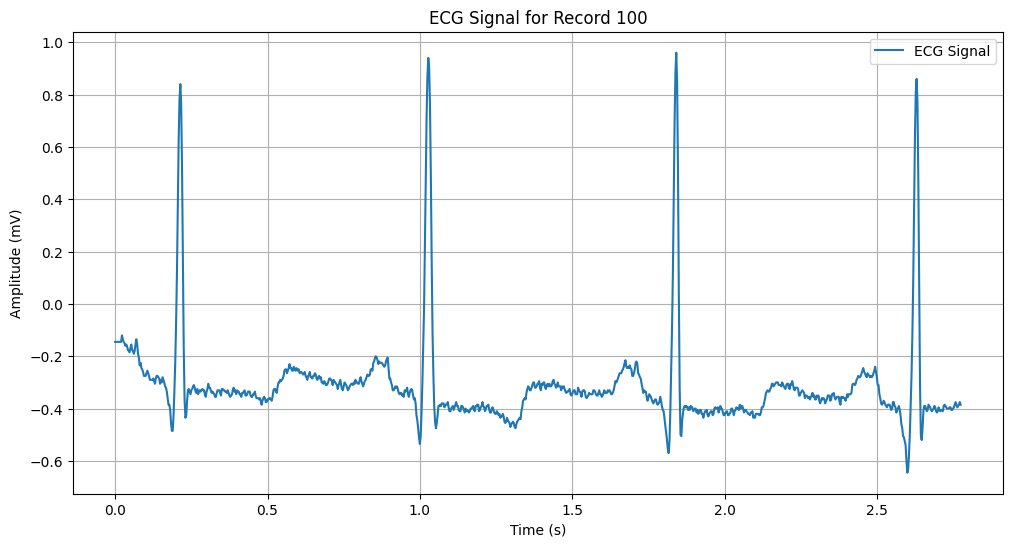

In [4]:
import os
import wfdb
import numpy as np
import matplotlib.pyplot as plt

# Function to locate and validate record files
def find_record_files(record_name, base_dirs):
    for base_dir in base_dirs:
        record_path = os.path.join(base_dir, record_name)
        if os.path.exists(f"{record_path}.hea") and os.path.exists(f"{record_path}.dat") and os.path.exists(f"{record_path}.atr"):
            print(f"Record {record_name} found in: {base_dir}")
            return {
                "hea": f"{record_path}.hea",
                "dat": f"{record_path}.dat",
                "atr": f"{record_path}.atr"
            }
    print(f"Record {record_name} not found in the specified directories.")
    return None

# Specify base directories to search for the dataset
base_dirs = [
    "/kaggle/input/mit-bih-noise-stress-test-dataset",
    "/kaggle/input/mit-bih-noise-stress-test-dataset/mit-bih-arrhythmia-database-1.0.0"
]

# Specify the record name to load
record_name = "100"
record_files = find_record_files(record_name, base_dirs)

if record_files:
    # Load the record and annotations
    record = wfdb.rdrecord(record_files["dat"][:-4])  # Remove extension for loading
    annotation = wfdb.rdann(record_files["atr"][:-4], 'atr')

    # Extract ECG signal and sampling frequency
    ecg_signal = record.p_signal[:, 0]  # Use the first channel
    fs = record.fs  # Sampling frequency
    time = np.arange(len(ecg_signal)) / fs  # Time vector in seconds

    # Plot the raw ECG signal
    plt.figure(figsize=(12, 6))
    plt.plot(time[:1000], ecg_signal[:1000], label="ECG Signal")
    plt.title(f"ECG Signal for Record {record_name}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (mV)")
    plt.grid()
    plt.legend()
    plt.show()
else:
    print("Failed to load record.")


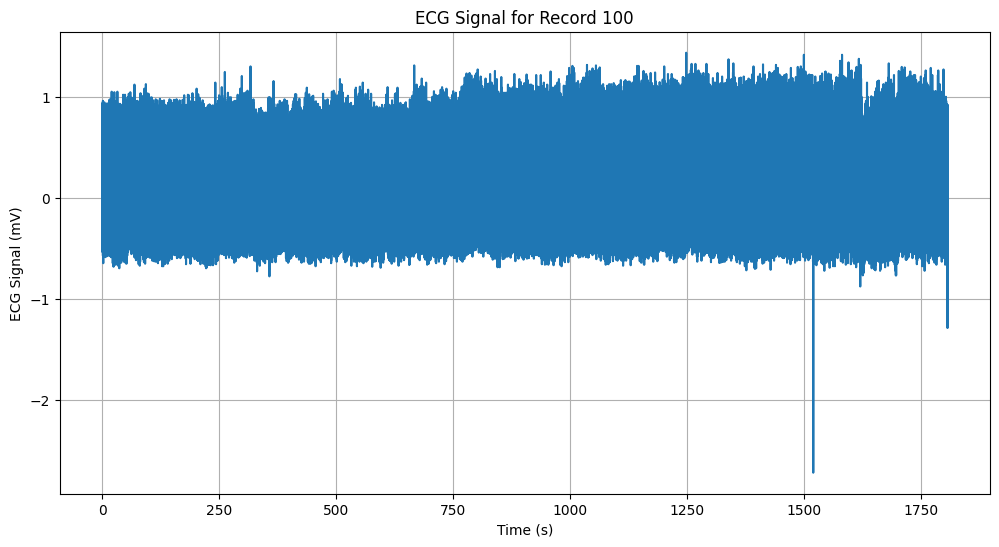

In [5]:
import matplotlib.pyplot as plt
import wfdb
import numpy as np

# Load record and annotation
record = wfdb.rdrecord('/kaggle/input/mit-bih-noise-stress-test-dataset/mit-bih-arrhythmia-database-1.0.0/100')
annotation = wfdb.rdann('/kaggle/input/mit-bih-noise-stress-test-dataset/mit-bih-arrhythmia-database-1.0.0/100', 'atr')

# Extract ECG signal (first channel)
ecg_signal = record.p_signal[:, 0]

# Create a time vector based on the sampling frequency (fs)
fs = record.fs  # Sampling frequency
time = np.arange(len(ecg_signal)) / fs  # Time in seconds

# Plot the ECG signal
plt.figure(figsize=(12, 6))
plt.plot(time, ecg_signal)
plt.title("ECG Signal for Record 100")
plt.xlabel("Time (s)")
plt.ylabel("ECG Signal (mV)")
plt.grid(True)
plt.show()


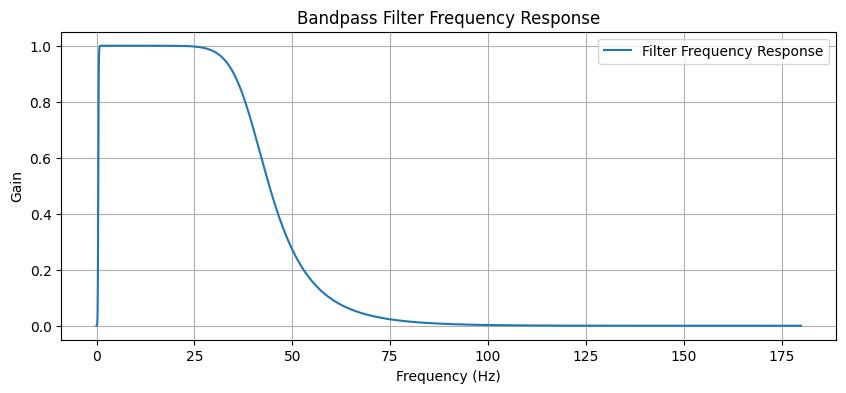

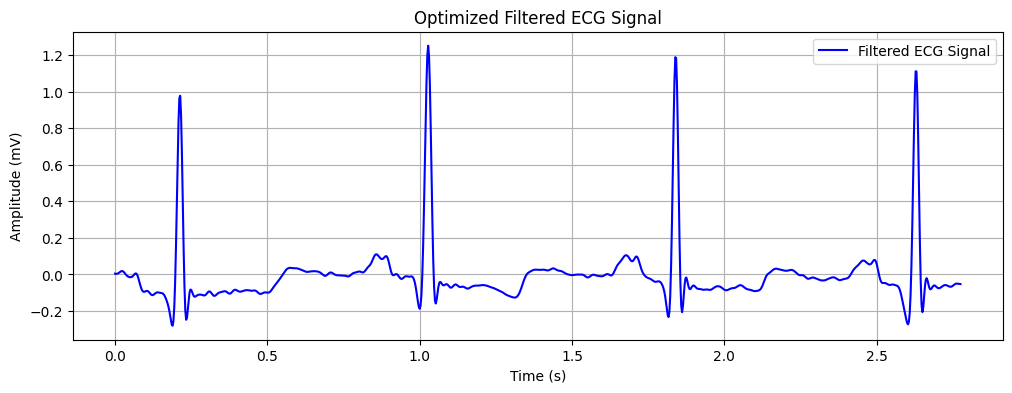

In [6]:
from scipy.signal import butter, filtfilt, freqz
import matplotlib.pyplot as plt

def optimized_bandpass_filter(signal, lowcut, highcut, fs, order=5):
    """
    Apply an optimized bandpass filter to an ECG signal.
    
    Parameters:
    - signal: The input ECG signal.
    - lowcut: Lower cutoff frequency (Hz).
    - highcut: Higher cutoff frequency (Hz).
    - fs: Sampling frequency (Hz).
    - order: Filter order (default=5 for sharper cutoff).
    
    Returns:
    - filtered_signal: The filtered ECG signal.
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist

    # Validate cutoff frequencies
    if low <= 0 or high >= 1:
        raise ValueError("Cutoff frequencies must be within the range (0, Nyquist).")
    
    # Design the filter
    b, a = butter(order, [low, high], btype='band')
    
    # Visualize the frequency response of the filter
    w, h = freqz(b, a, worN=8000)
    plt.figure(figsize=(10, 4))
    plt.plot(0.5 * fs * w / np.pi, abs(h), label="Filter Frequency Response")
    plt.title("Bandpass Filter Frequency Response")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Gain")
    plt.grid()
    plt.legend()
    plt.show()
    
    # Apply zero-phase filtering
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Apply the optimized bandpass filter
lowcut = 0.5  # Lower cutoff frequency (Hz)
highcut = 40  # Higher cutoff frequency (Hz)
filtered_ecg = optimized_bandpass_filter(ecg_signal, lowcut, highcut, fs)

# Plot the filtered ECG signal
plt.figure(figsize=(12, 4))
plt.plot(time[:1000], filtered_ecg[:1000], label="Filtered ECG Signal", color='blue')
plt.title("Optimized Filtered ECG Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.grid()
plt.legend()
plt.show()


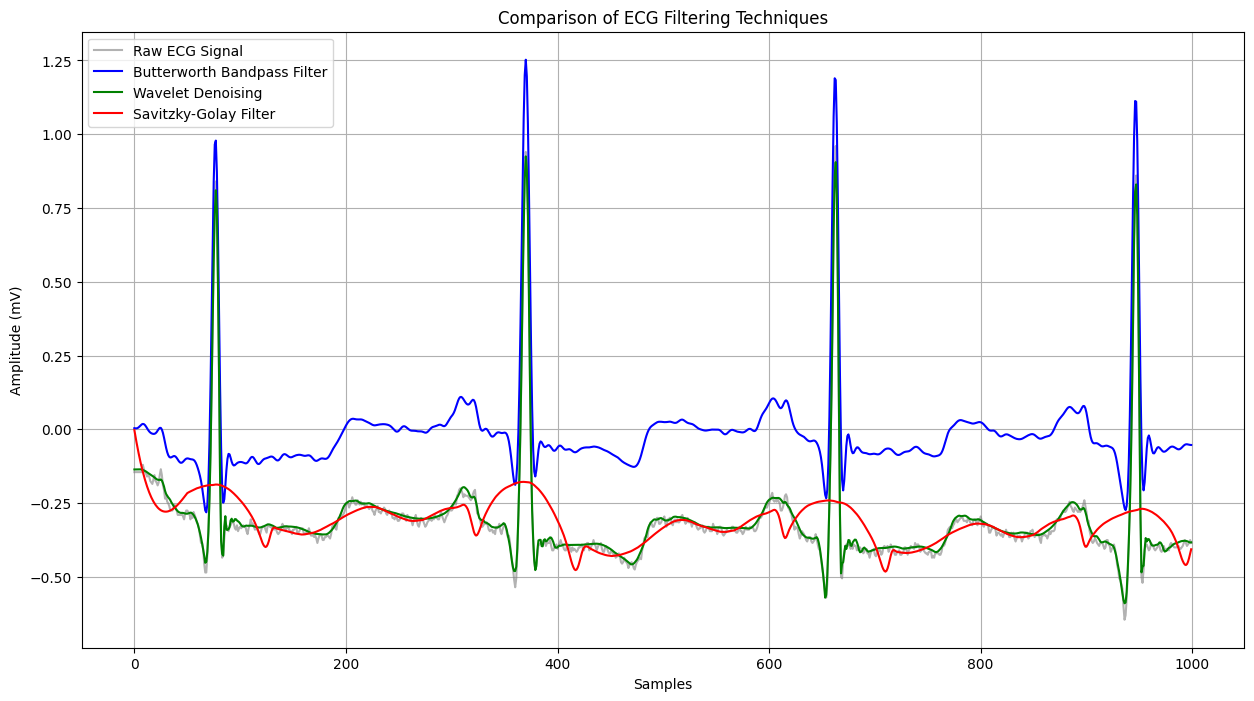

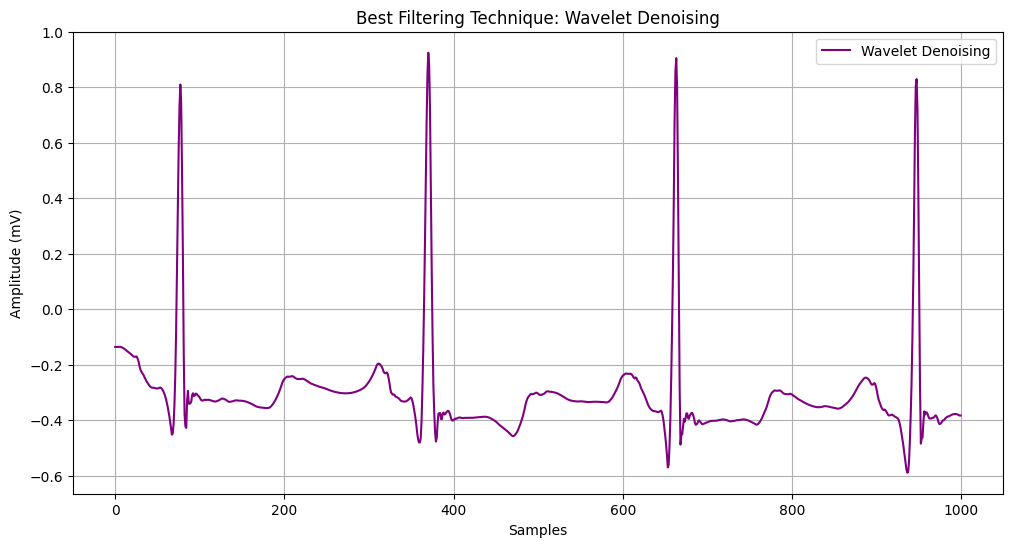

In [7]:
from scipy.signal import butter, filtfilt, savgol_filter
import pywt
import matplotlib.pyplot as plt
import numpy as np

# Function: Butterworth Bandpass Filter
def butter_bandpass_filter(signal, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# Function: Wavelet Denoising
def wavelet_denoising(signal, wavelet='db4', level=4):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
    coeffs = [pywt.threshold(c, uthresh, mode='soft') for c in coeffs]
    return pywt.waverec(coeffs, wavelet)

# Function: Savitzky-Golay Filter
def savgol_filtering(signal, window_length, polyorder):
    return savgol_filter(signal, window_length, polyorder)

# Parameters
lowcut = 0.5
highcut = 40
fs = 360  # Sampling frequency
order = 5
window_length = 101  # For Savitzky-Golay filter
polyorder = 3

# Apply filters
butter_filtered = butter_bandpass_filter(ecg_signal, lowcut, highcut, fs, order)
wavelet_filtered = wavelet_denoising(ecg_signal)
savgol_filtered = savgol_filtering(ecg_signal, window_length, polyorder)

# Plot raw and filtered signals
plt.figure(figsize=(15, 8))
plt.plot(ecg_signal[:1000], label="Raw ECG Signal", color='gray', alpha=0.6)
plt.plot(butter_filtered[:1000], label="Butterworth Bandpass Filter", color='blue')
plt.plot(wavelet_filtered[:1000], label="Wavelet Denoising", color='green')
plt.plot(savgol_filtered[:1000], label="Savitzky-Golay Filter", color='red')
plt.title("Comparison of ECG Filtering Techniques")
plt.xlabel("Samples")
plt.ylabel("Amplitude (mV)")
plt.legend()
plt.grid()
plt.show()

# Function to identify the best filtering output visually
def plot_best_filtering(filtered_signal, label):
    plt.figure(figsize=(12, 6))
    plt.plot(filtered_signal[:1000], label=label, color='purple')
    plt.title(f"Best Filtering Technique: {label}")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude (mV)")
    plt.grid()
    plt.legend()
    plt.show()

# Compare and decide best filter visually
# Plot the best filtering result (choose manually after comparing)
best_filtered_signal = wavelet_filtered  # Example: Choose wavelet filtering
plot_best_filtering(best_filtered_signal, "Wavelet Denoising")


In [8]:
# Load annotations
annotations = wfdb.rdann('/kaggle/input/mit-bih-noise-stress-test-dataset/mit-bih-arrhythmia-database-1.0.0/100', 'atr')

# Extract annotation information
annotation_symbols = annotations.symbol  # The labels for each annotation
annotation_sample_indices = annotations.sample  # Sample indices of the annotations

# Display some annotations to understand the structure
print("Annotation symbols (first 10):", annotation_symbols[:10])
print("Annotation sample indices (first 10):", annotation_sample_indices[:10])


Annotation symbols (first 10): ['+', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'A', 'N']
Annotation sample indices (first 10): [  18   77  370  662  946 1231 1515 1809 2044 2402]


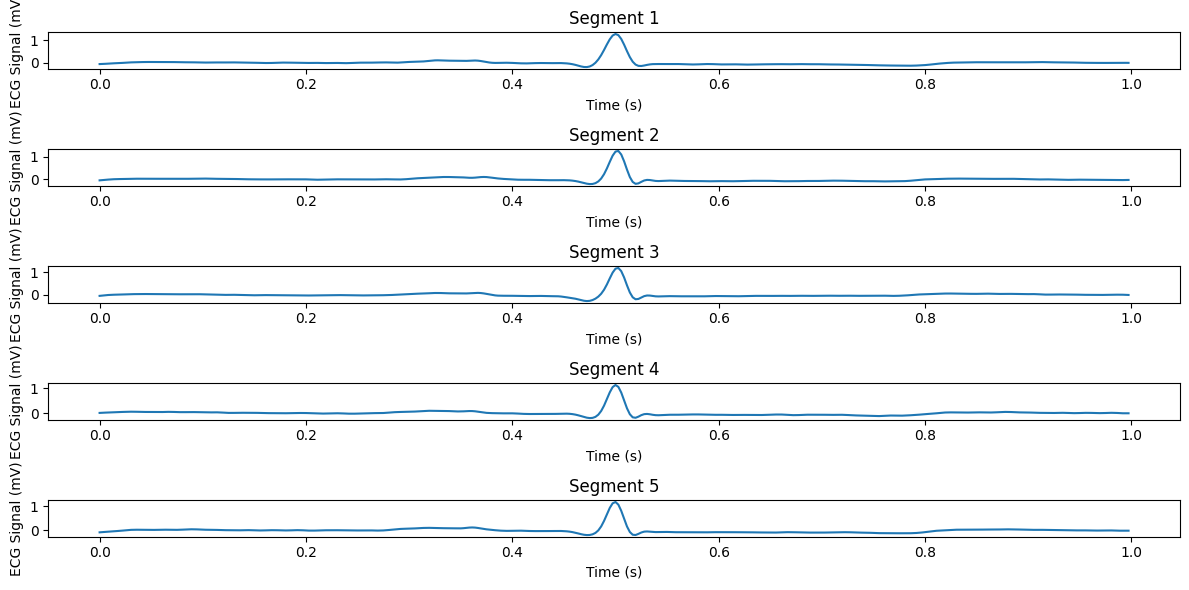

In [16]:
# Example: Segmenting the ECG signal around a specific annotation
# Here, we'll extract 1-second windows around each annotation to inspect individual beats

segment_duration = 1  # Duration of the segment in seconds (before and after annotation)

segments = []
for idx in range(len(annotation_sample_indices)):
    # Extract segment around the annotation sample
    start_idx = annotation_sample_indices[idx] - int(segment_duration * fs / 2)
    end_idx = annotation_sample_indices[idx] + int(segment_duration * fs / 2)
    
    # Ensure indices are within the bounds of the signal length
    if start_idx >= 0 and end_idx < len(filtered_ecg):
        segment = filtered_ecg[start_idx:end_idx]
        segments.append(segment)

# Plot a few segments
plt.figure(figsize=(12, 6))
for i in range(min(5, len(segments))):  # Plot up to 5 segments
    plt.subplot(5, 1, i+1)
    plt.plot(np.arange(len(segments[i])) / fs, segments[i])
    plt.title(f"Segment {i+1}")
    plt.xlabel("Time (s)")
    plt.ylabel("ECG Signal (mV)")
plt.tight_layout()
plt.show()


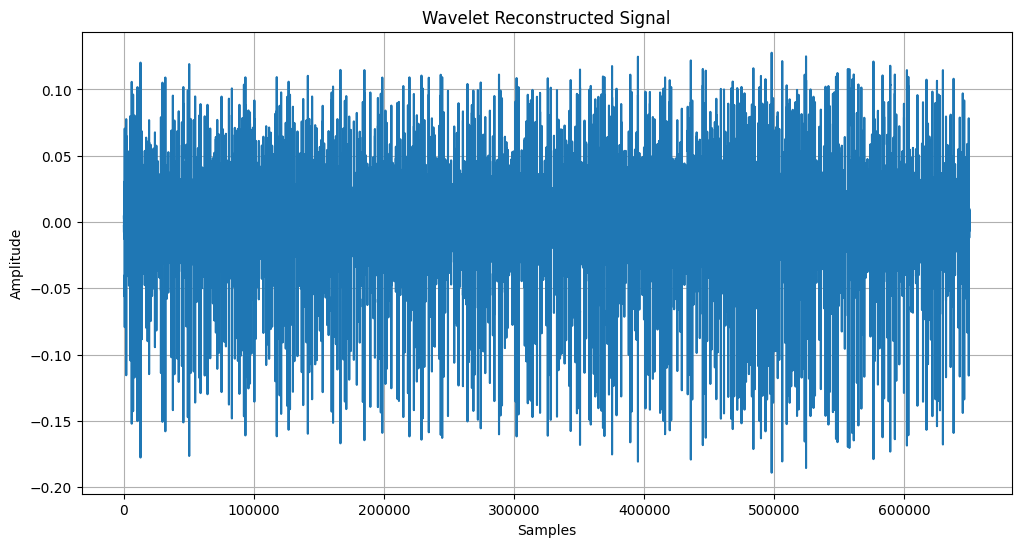

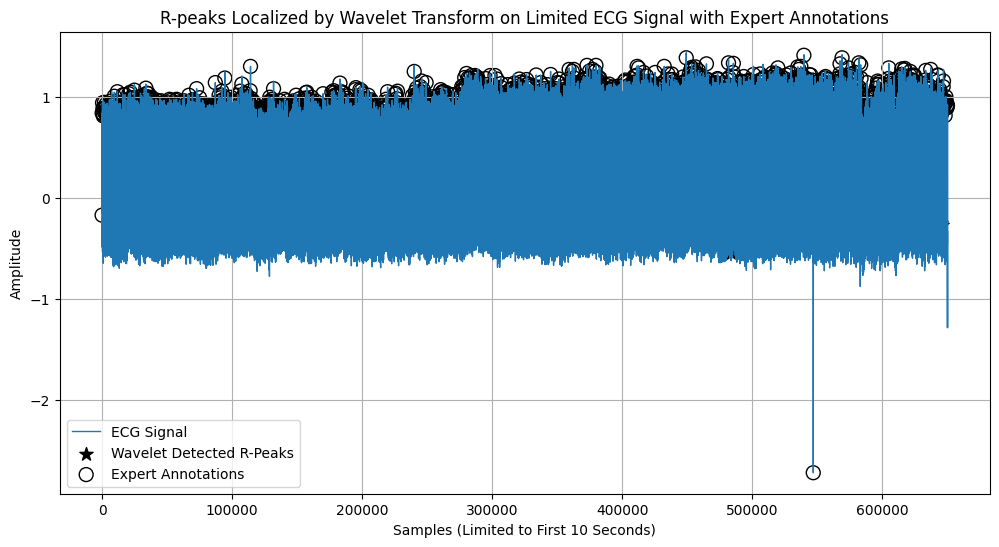

Total R-peaks Annotated by Experts in Segment: 2274
Total R-peaks Detected by Wavelet in Segment: 166
Correct Detections (within ±50 ms): 21
False Positives: 145
False Negatives: 2253
Detection Accuracy: 0.92%


In [22]:
base_dir = "/kaggle/input/mit-bih-noise-stress-test-dataset/mit-bih-arrhythmia-database-1.0.0/"
record_name = "100"  # Change as per the record in use
record = wfdb.rdrecord(os.path.join(base_dir, record_name))
annotation = wfdb.rdann(os.path.join(base_dir, record_name), 'atr')
ecg_signal = record.p_signal[:, 0]
fs = record.fs  # Sampling frequency
start_time = 0
end_time = 11000
start_sample = int(start_time * fs)
end_sample = int(end_time * fs)
limited_ecg_signal = ecg_signal[start_sample:end_sample]
limited_annotations = annotation.sample[
    (annotation.sample >= start_sample) & (annotation.sample < end_sample)
] - start_sample
if len(limited_annotations) == 0:
    print("No annotations found in the specified range. Adjust the time range.")
    exit()
coeffs = pywt.wavedec(limited_ecg_signal, 'db4', level=4)
d4 = coeffs[3]  # Experiment with level (e.g., 2, 3, 4)
reconstructed_signal = pywt.upcoef('d', d4, 'db4', level=4, take=len(limited_ecg_signal))
plt.figure(figsize=(12, 6))
plt.plot(reconstructed_signal, label="Reconstructed Signal (Wavelet D4)")
plt.title("Wavelet Reconstructed Signal")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()
peaks, _ = find_peaks(reconstructed_signal, distance=int(fs * 0.6), prominence=0.2)
plt.figure(figsize=(12, 6))
plt.plot(limited_ecg_signal, label='ECG Signal', linewidth=1)
plt.scatter(peaks, limited_ecg_signal[peaks], color='black', marker='*', label='Wavelet Detected R-Peaks', s=100)
plt.scatter(limited_annotations, limited_ecg_signal[limited_annotations], color='red', edgecolors='black',
            label='Expert Annotations', s=100, facecolors='none')
plt.title("R-peaks Localized by Wavelet Transform on Limited ECG Signal with Expert Annotations")
plt.xlabel("Samples (Limited to First 10 Seconds)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()
tolerance = int(0.05 * fs)  # 50 ms tolerance
correct_detections = sum(np.any(np.abs(peaks - true_r) <= tolerance) for true_r in limited_annotations)
false_positives = len(peaks) - correct_detections
false_negatives = len(limited_annotations) - correct_detections
print(f"Total R-peaks Annotated by Experts in Segment: {len(limited_annotations)}")
print(f"Total R-peaks Detected by Wavelet in Segment: {len(peaks)}")
print(f"Correct Detections (within ±50 ms): {correct_detections}")
print(f"False Positives: {false_positives}")
print(f"False Negatives: {false_negatives}")
print(f"Detection Accuracy: {correct_detections / len(limited_annotations) * 100:.2f}%")


In [23]:
# Calculate the HRV (Heart Rate Variability) - Standard Deviation of RR intervals
hrv = np.std(rr_intervals)

# Print HRV result
print(f"Heart Rate Variability (HRV) for Record 100: {hrv:.4f} seconds")


Heart Rate Variability (HRV) for Record 100: 0.0481 seconds


Record loaded: 100
RR Intervals (ms): [163.88888889 813.88888889 811.11111111 ... 700.         694.44444444
 713.88888889]

Time-Domain Metrics:
SDNN: 50.58 ms
RMSSD: 64.67 ms
NN50: 228
PNN50: 10.03%


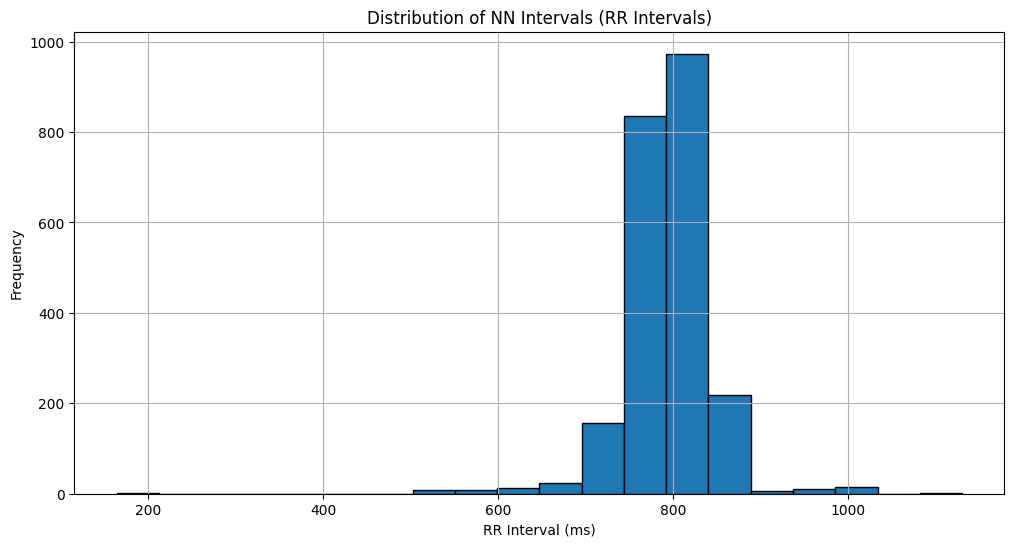


Frequency-Domain Metrics:
LF Power: 10853.58
HF Power: 2674.38
LF/HF Ratio: 4.06


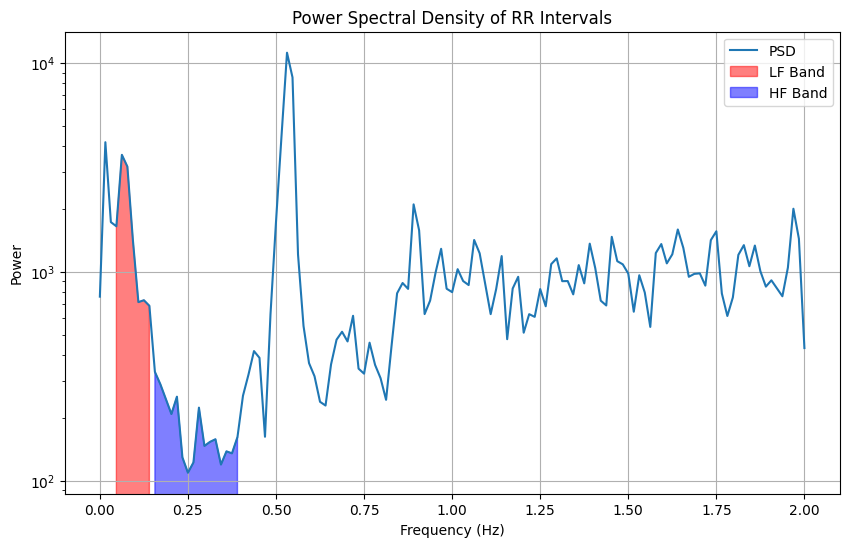

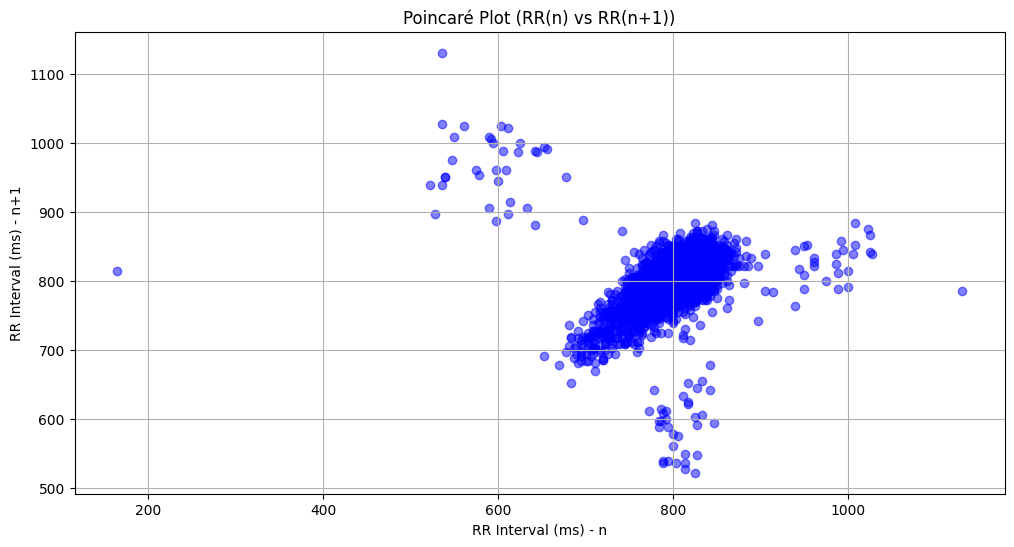

In [27]:
from scipy.signal import welch
base_dir = "/kaggle/input/mit-bih-noise-stress-test-dataset/mit-bih-arrhythmia-database-1.0.0/"
records = {}
for file in os.listdir(base_dir):
    if file.endswith(".hea") or file.endswith(".atr") or file.endswith(".dat"):
        record_name = file.split(".")[0]  # Extract record name
        if record_name not in records:
            records[record_name] = {}
        file_type = file.split(".")[1]  # Identify file type (hea, atr, dat)
        records[record_name][file_type] = os.path.join(base_dir, file)

# Select a specific record (e.g., "100")
record_name = "100"
hea_path = records[record_name].get("hea")
atr_path = records[record_name].get("atr")
dat_path = records[record_name].get("dat")

# Load the record and annotation
record = wfdb.rdrecord(dat_path[:-4])  # Remove ".dat" extension
annotation = wfdb.rdann(atr_path[:-4], 'atr')

print(f"Record loaded: {record.record_name}")
r_peaks = annotation.sample
rr_intervals = np.diff(r_peaks) / record.fs * 1000  # Convert to milliseconds
print(f"RR Intervals (ms): {rr_intervals}")
sdnn = np.std(rr_intervals)  # Standard deviation of RR intervals
rmssd = np.sqrt(np.mean(np.square(np.diff(rr_intervals))))  # Root mean square of successive differences
nn50 = np.sum(np.abs(np.diff(rr_intervals)) > 50)  # Number of pairs > 50 ms
pnn50 = nn50 / len(rr_intervals) * 100  # Percentage of NN50

print("\nTime-Domain Metrics:")
print(f"SDNN: {sdnn:.2f} ms")
print(f"RMSSD: {rmssd:.2f} ms")
print(f"NN50: {nn50}")
print(f"PNN50: {pnn50:.2f}%")
plt.figure(figsize=(12, 6))
plt.hist(rr_intervals, bins=20, edgecolor='black')
plt.title("Distribution of NN Intervals (RR Intervals)")
plt.xlabel("RR Interval (ms)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# 2. Frequency-Domain HRV Metrics using Welch's method
f, psd = welch(rr_intervals, fs=4.0, nperseg=256)  # Resample and calculate PSD
lf_power = np.trapz(psd[(f >= 0.04) & (f <= 0.15)])  # LF band (0.04–0.15 Hz)
hf_power = np.trapz(psd[(f >= 0.15) & (f <= 0.4)])  # HF band (0.15–0.4 Hz)
lf_hf_ratio = lf_power / hf_power

print("\nFrequency-Domain Metrics:")
print(f"LF Power: {lf_power:.2f}")
print(f"HF Power: {hf_power:.2f}")
print(f"LF/HF Ratio: {lf_hf_ratio:.2f}")

# Plot Power Spectral Density
plt.figure(figsize=(10, 6))
plt.semilogy(f, psd, label='PSD')
plt.fill_between(f[(f >= 0.04) & (f <= 0.15)], psd[(f >= 0.04) & (f <= 0.15)], color='red', alpha=0.5, label='LF Band')
plt.fill_between(f[(f >= 0.15) & (f <= 0.4)], psd[(f >= 0.15) & (f <= 0.4)], color='blue', alpha=0.5, label='HF Band')
plt.title("Power Spectral Density of RR Intervals")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.legend()
plt.grid()
plt.show()

# 3. Poincaré Plot (Scatter of consecutive RR intervals)
plt.figure(figsize=(12, 6))
plt.scatter(rr_intervals[:-1], rr_intervals[1:], alpha=0.5, color='blue')
plt.title("Poincaré Plot (RR(n) vs RR(n+1))")
plt.xlabel("RR Interval (ms) - n")
plt.ylabel("RR Interval (ms) - n+1")
plt.grid(True)
plt.show()


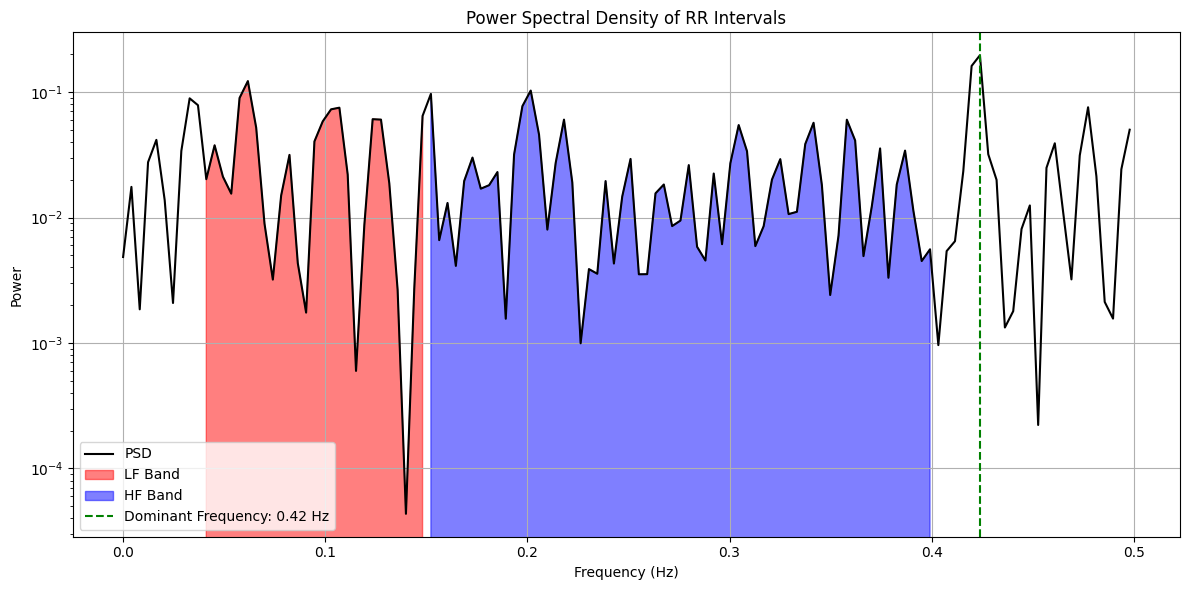

Dominant Frequency: 0.42 Hz


In [41]:
from scipy.signal import find_peaks, welch
import pywt
def calculate_rr_intervals(r_peaks, fs):
    rr_intervals = np.diff(r_peaks) / fs  # in seconds
    return rr_intervals
ecg_signal = filtered_signal  # From previous processing
fs = 5000  # Example sampling frequency (Hz)
peaks, _ = find_peaks(ecg_signal, distance=fs*0.4, prominence=0.1)
rr_intervals = calculate_rr_intervals(peaks, fs)
f, psd = welch(rr_intervals, fs=1, nperseg=len(rr_intervals))
dominant_frequency = f[np.argmax(psd)]
plt.figure(figsize=(12, 6))
plt.semilogy(f, psd, label='PSD', color='black')
plt.fill_between(f[(f >= 0.04) & (f <= 0.15)], psd[(f >= 0.04) & (f <= 0.15)], color='red', alpha=0.5, label='LF Band')
plt.fill_between(f[(f >= 0.15) & (f <= 0.4)], psd[(f >= 0.15) & (f <= 0.4)], color='blue', alpha=0.5, label='HF Band')
plt.axvline(dominant_frequency, color='green', linestyle='--', label=f'Dominant Frequency: {dominant_frequency:.2f} Hz')
plt.title("Power Spectral Density of RR Intervals")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("psd_plot.png", bbox_inches='tight')
plt.show()
print(f"Dominant Frequency: {dominant_frequency:.2f} Hz")



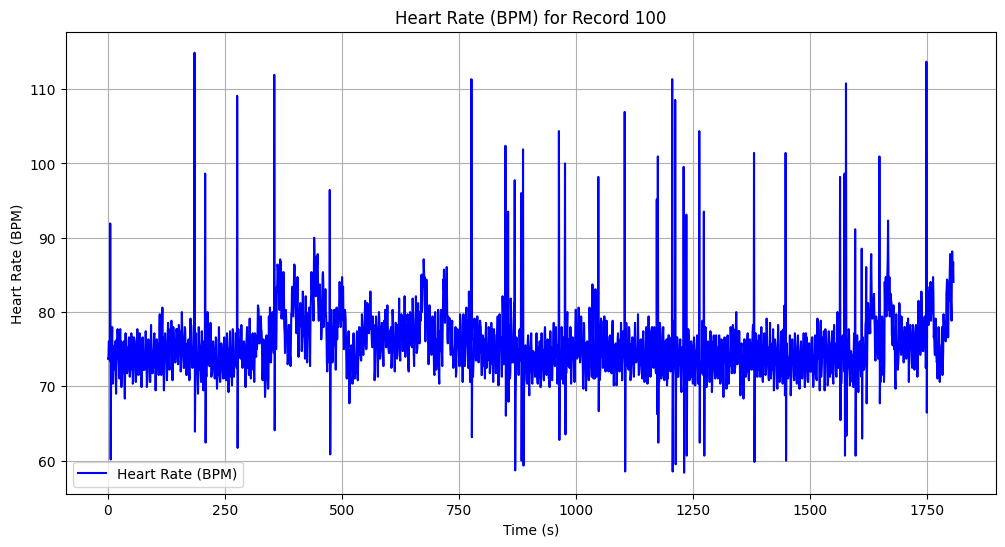

In [26]:
heart_rate = 60 / rr_intervals  # in beats per minute (BPM)
plt.figure(figsize=(12, 6))
plt.plot(r_peaks[1:] / fs, heart_rate, label="Heart Rate (BPM)", color="b")
plt.title("Heart Rate (BPM) for Record 100")
plt.xlabel("Time (s)")
plt.ylabel("Heart Rate (BPM)")
plt.grid(True)
plt.legend()
plt.show()


In [81]:
import os
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Base directory for dataset
base_dir = "/kaggle/input/mit-bih-noise-stress-test-dataset/mit-bih-arrhythmia-database-1.0.0/"

# Organize dataset files by record name
records = {}
for file in os.listdir(base_dir):
    if file.endswith(".hea") or file.endswith(".atr") or file.endswith(".dat"):
        record_name = file.split(".")[0]
        if record_name not in records:
            records[record_name] = {}
        file_type = file.split(".")[1]
        records[record_name][file_type] = os.path.join(base_dir, file)

# Select specific record
record_name = "100"
hea_path = records[record_name].get("hea")
atr_path = records[record_name].get("atr")
dat_path = records[record_name].get("dat")

# Load ECG signal
record = wfdb.rdrecord(dat_path[:-4])
annotation = wfdb.rdann(atr_path[:-4], 'atr')

# Extract single lead for processing
ecg_signal = record.p_signal[:, 0]
fs = record.fs  # Sampling frequency

# Detect R-peaks using find_peaks (you can adjust the prominence and distance parameters)
peaks, _ = find_peaks(ecg_signal, distance=fs * 0.6, prominence=0.2)  # 0.6 sec = 600 ms interval for HR

# Calculate RR intervals (time between consecutive R-peaks in seconds)
rr_intervals = np.diff(peaks) / fs  # Convert sample index differences to time in seconds

# Calculate heart rate (in beats per minute) for each RR interval
heart_rate = 60 / rr_intervals  # Heart rate in BPM (beats per minute)

# Trend analysis - moving average of heart rate (e.g., 10-point moving average)
window_size = 10  # Moving average window size (10 data points)
moving_avg_hr = np.convolve(heart_rate, np.ones(window_size)/window_size, mode='valid')

# Create a directory to save the output if it doesn't exist
output_dir = "output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Plot the heart rate and trend
plt.figure(figsize=(12, 6))

# Plot heart rate
plt.subplot(2, 1, 1)
plt.plot(heart_rate, label="Heart Rate (BPM)", color="b")
plt.title("Heart Rate (BPM) over Time")
plt.xlabel("R-Peak Index")
plt.ylabel("Heart Rate (BPM)")
plt.grid(True)
plt.legend()

# Plot moving average of heart rate (Trend Analysis)
plt.subplot(2, 1, 2)
plt.plot(moving_avg_hr, label="Moving Average Heart Rate", color="r")
plt.title("Heart Rate Trend Analysis (Moving Average)")
plt.xlabel("R-Peak Index")
plt.ylabel("Heart Rate (BPM)")
plt.grid(True)
plt.legend()

plt.tight_layout()

# Save the plots as image files
plt.savefig(os.path.join(output_dir, "heart_rate_and_trend_analysis.png"))
plt.close()  # Close the plot to avoid displaying it multiple times

# Save heart rate and moving average to a CSV file
import pandas as pd
df = pd.DataFrame({
    "Heart Rate (BPM)": heart_rate,
    "Moving Average Heart Rate (BPM)": np.concatenate(([np.nan] * (window_size - 1), moving_avg_hr))  # Align lengths
})

df.to_csv(os.path.join(output_dir, "heart_rate_and_moving_avg.csv"), index=False)

# Optional: Print some heart rate and trend statistics
print(f"Heart Rate (first 10 values): {heart_rate[:10]}")
print(f"Moving Average Heart Rate (first 10 values): {moving_avg_hr[:10]}")


Heart Rate (first 10 values): [73.72013652 73.72013652 76.05633803 76.05633803 76.05633803 73.46938776
 91.52542373 60.33519553 71.28712871 73.97260274]
Moving Average Heart Rate (first 10 values): [74.61990256 74.82683628 75.25265656 74.77573563 74.18308884 73.89948893
 73.77663042 71.92138535 73.44031335 73.83773288]


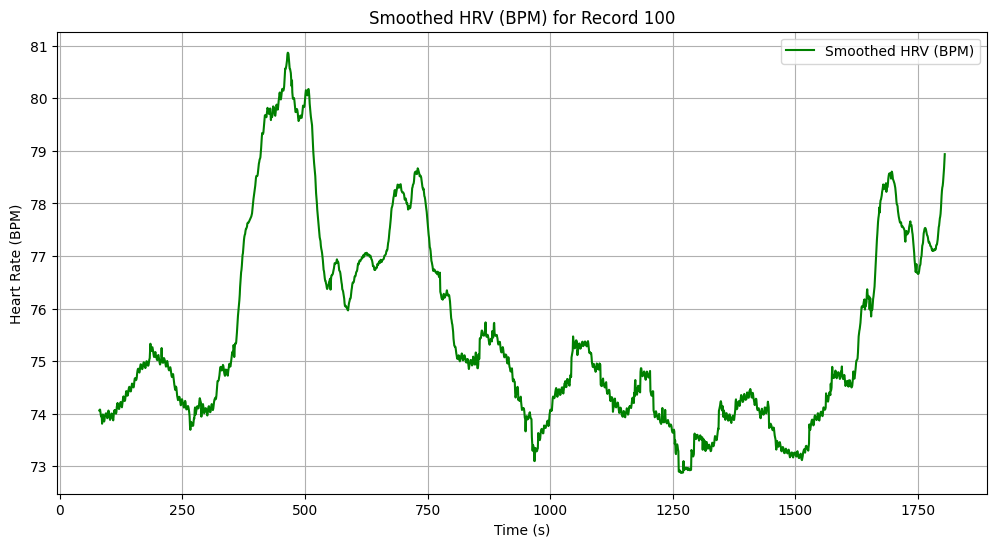

Smoothed HRV (first 10 values): [74.05935762 74.0747695  74.07729416 74.01575991 73.96339325 73.9425559
 73.96310677 73.80841592 73.9576772  73.98453194]


In [82]:
import os
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Base directory for dataset
base_dir = "/kaggle/input/mit-bih-noise-stress-test-dataset/mit-bih-arrhythmia-database-1.0.0/"

# Organize dataset files by record name
records = {}
for file in os.listdir(base_dir):
    if file.endswith(".hea") or file.endswith(".atr") or file.endswith(".dat"):
        record_name = file.split(".")[0]
        if record_name not in records:
            records[record_name] = {}
        file_type = file.split(".")[1]
        records[record_name][file_type] = os.path.join(base_dir, file)

# Select specific record
record_name = "100"
hea_path = records[record_name].get("hea")
atr_path = records[record_name].get("atr")
dat_path = records[record_name].get("dat")

# Load ECG signal
record = wfdb.rdrecord(dat_path[:-4])
annotation = wfdb.rdann(atr_path[:-4], 'atr')

# Extract single lead for processing
ecg_signal = record.p_signal[:, 0]
fs = record.fs  # Sampling frequency

# Detect R-peaks using find_peaks (you can adjust the prominence and distance parameters)
peaks, _ = find_peaks(ecg_signal, distance=fs * 0.6, prominence=0.2)  # 0.6 sec = 600 ms interval for HR

# Calculate RR intervals (time between consecutive R-peaks in seconds)
rr_intervals = np.diff(peaks) / fs  # Convert sample index differences to time in seconds

# Calculate heart rate (in beats per minute) for each RR interval
heart_rate = 60 / rr_intervals  # Heart rate in BPM (beats per minute)

# Optional: Create a rolling window for smoothing the HRV or heart rate
window_size = 100  # Adjust window size for smoothing
smooth_hrv = np.convolve(heart_rate, np.ones(window_size) / window_size, mode='valid')

# Adjust the r_peaks time to align with the smoothed heart rate
smoothed_time = peaks[window_size - 1:] / fs  # Adjust time based on the smoothed heart rate

# Ensure the time and HRV arrays are the same length
smoothed_time = smoothed_time[:len(smooth_hrv)]  # Match the lengths

# Plot the smoothed HRV over time
plt.figure(figsize=(12, 6))
plt.plot(smoothed_time, smooth_hrv, label="Smoothed HRV (BPM)", color="g")
plt.title("Smoothed HRV (BPM) for Record 100")
plt.xlabel("Time (s)")
plt.ylabel("Heart Rate (BPM)")
plt.grid(True)
plt.legend()
plt.show()

# Optional: Save the plot and smoothed HRV data
output_dir = "output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save plot as image
plt.savefig(os.path.join(output_dir, "smoothed_hrv_plot.png"))
plt.close()

# Save the smoothed HRV and corresponding time to a CSV file
import pandas as pd
df = pd.DataFrame({
    "Time (s)": smoothed_time,
    "Smoothed HRV (BPM)": smooth_hrv
})

df.to_csv(os.path.join(output_dir, "smoothed_hrv.csv"), index=False)

# Optional: Print some of the smoothed HRV values
print(f"Smoothed HRV (first 10 values): {smooth_hrv[:10]}")


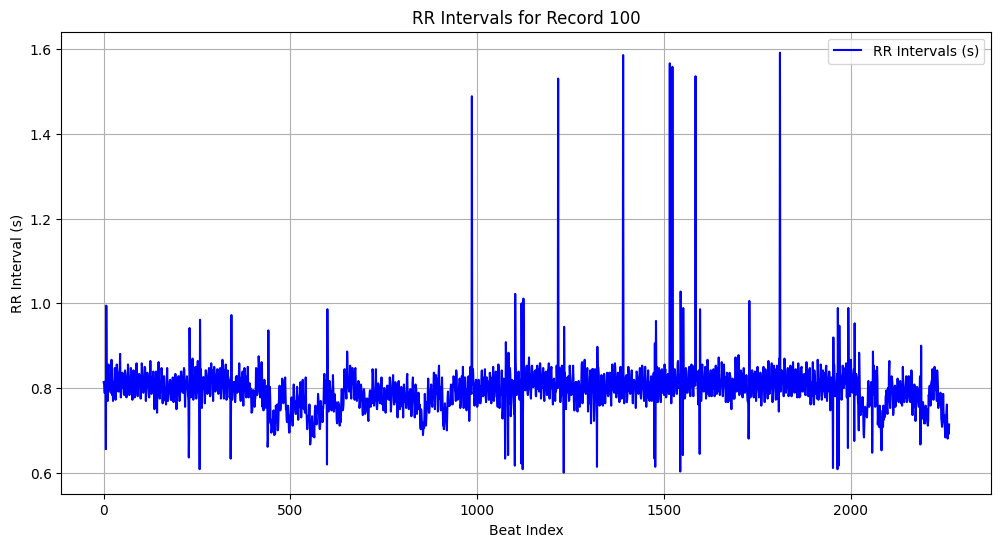

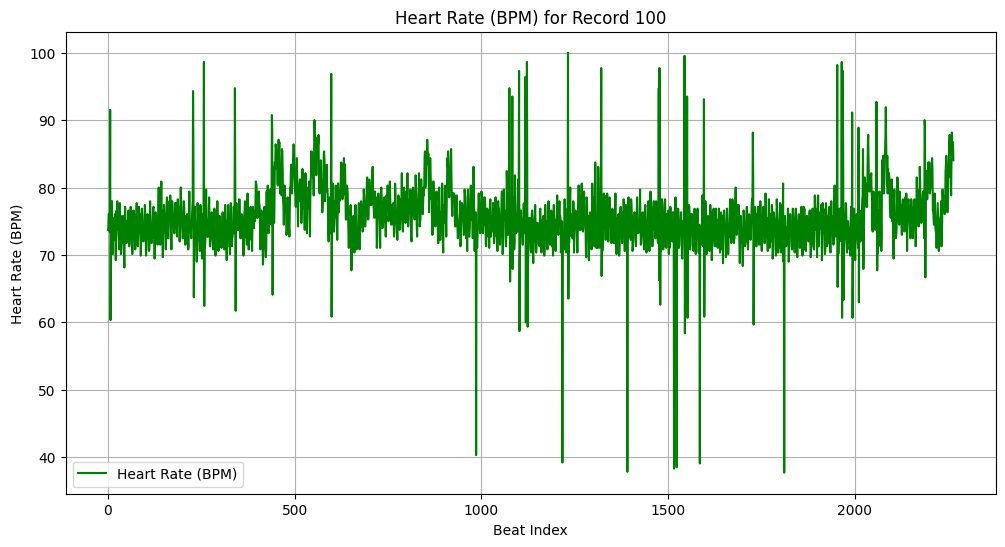

SDNN (Standard Deviation of NN intervals) for Record 100: 0.06 seconds


In [83]:
import os
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Base directory for dataset
base_dir = "/kaggle/input/mit-bih-noise-stress-test-dataset/mit-bih-arrhythmia-database-1.0.0/"

# Organize dataset files by record name
records = {}
for file in os.listdir(base_dir):
    if file.endswith(".hea") or file.endswith(".atr") or file.endswith(".dat"):
        record_name = file.split(".")[0]
        if record_name not in records:
            records[record_name] = {}
        file_type = file.split(".")[1]
        records[record_name][file_type] = os.path.join(base_dir, file)

# Select specific record
record_name = "100"
hea_path = records[record_name].get("hea")
atr_path = records[record_name].get("atr")
dat_path = records[record_name].get("dat")

# Load ECG signal
record = wfdb.rdrecord(dat_path[:-4])
annotation = wfdb.rdann(atr_path[:-4], 'atr')

# Extract single lead for processing
ecg_signal = record.p_signal[:, 0]
fs = record.fs  # Sampling frequency

# Detect R-peaks using find_peaks (you can adjust the prominence and distance parameters)
peaks, _ = find_peaks(ecg_signal, distance=fs * 0.6, prominence=0.2)  # 0.6 sec = 600 ms interval for HR

# Calculate RR intervals (time between consecutive R-peaks in seconds)
rr_intervals = np.diff(peaks) / fs  # Convert sample index differences to time in seconds

# Calculate heart rate (in beats per minute) for each RR interval
heart_rate = 60 / rr_intervals  # Heart rate in BPM (beats per minute)

# Compute SDNN (Standard Deviation of NN intervals)
sdnn = np.std(rr_intervals)  # Standard deviation of RR intervals in seconds

# Plot RR intervals
plt.figure(figsize=(12, 6))
plt.plot(rr_intervals, label="RR Intervals (s)", color='b')
plt.title(f"RR Intervals for Record {record_name}")
plt.xlabel("Beat Index")
plt.ylabel("RR Interval (s)")
plt.grid(True)
plt.legend()
plt.show()

# Plot Heart Rate (HR) derived from RR intervals
plt.figure(figsize=(12, 6))
plt.plot(heart_rate, label="Heart Rate (BPM)", color='g')
plt.title(f"Heart Rate (BPM) for Record {record_name}")
plt.xlabel("Beat Index")
plt.ylabel("Heart Rate (BPM)")
plt.grid(True)
plt.legend()
plt.show()

# Print SDNN metric
print(f"SDNN (Standard Deviation of NN intervals) for Record {record_name}: {sdnn:.2f} seconds")

# Optional: Save output
output_dir = "output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the RR interval plot
plt.figure(figsize=(12, 6))
plt.plot(rr_intervals, label="RR Intervals (s)", color='b')
plt.title(f"RR Intervals for Record {record_name}")
plt.xlabel("Beat Index")
plt.ylabel("RR Interval (s)")
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(output_dir, "rr_intervals_plot.png"))
plt.close()

# Save the Heart Rate plot
plt.figure(figsize=(12, 6))
plt.plot(heart_rate, label="Heart Rate (BPM)", color='g')
plt.title(f"Heart Rate (BPM) for Record {record_name}")
plt.xlabel("Beat Index")
plt.ylabel("Heart Rate (BPM)")
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(output_dir, "heart_rate_plot.png"))
plt.close()

# Save the SDNN value to a text file
with open(os.path.join(output_dir, "sdnn.txt"), 'w') as file:
    file.write(f"SDNN for Record {record_name}: {sdnn:.2f} seconds\n")

# Optional: Save RR intervals and heart rate data to CSV
import pandas as pd
df = pd.DataFrame({
    "RR Interval (s)": rr_intervals,
    "Heart Rate (BPM)": heart_rate
})

df.to_csv(os.path.join(output_dir, "rr_intervals_and_heart_rate.csv"), index=False)
